In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler,RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, accuracy_score, f1_score,confusion_matrix,precision_score, recall_score,roc_auc_score,precision_recall_curve,balanced_accuracy_score
import optuna

In [2]:
df=pd.read_csv('CICIDS2018/02-14-2018.csv')

In [3]:
df.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,14/02/2018 08:31:01,112641719,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,0,0,14/02/2018 08:33:50,112641466,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign
2,0,0,14/02/2018 08:36:39,112638623,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,Benign
3,22,6,14/02/2018 08:40:13,6453966,15,10,1239,2273,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
4,22,6,14/02/2018 08:40:23,8804066,14,11,1143,2209,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign


In [4]:
df.shape

(1048575, 80)

In [5]:
df['Label'].value_counts()

Label
Benign            667626
FTP-BruteForce    193360
SSH-Bruteforce    187589
Name: count, dtype: int64

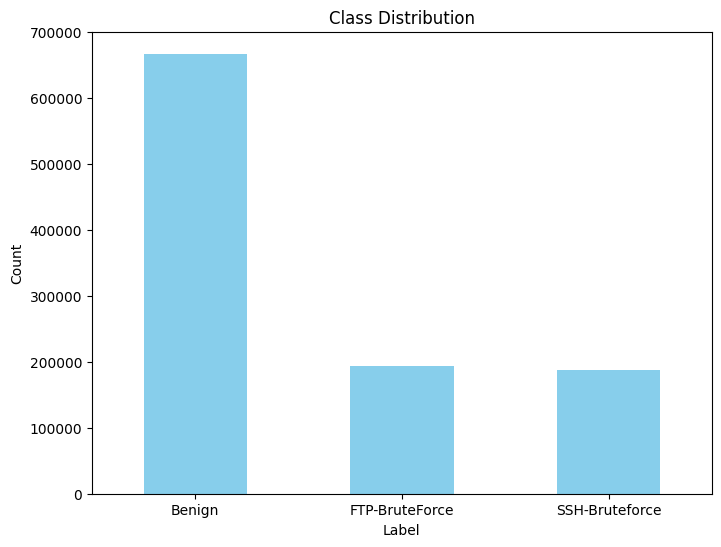

In [25]:
label_counts = df['Label'].value_counts()

# Option 1: Bar Chart
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [6]:
df.isnull().sum()

Dst Port         0
Protocol         0
Timestamp        0
Flow Duration    0
Tot Fwd Pkts     0
                ..
Idle Mean        0
Idle Std         0
Idle Max         0
Idle Min         0
Label            0
Length: 80, dtype: int64

In [7]:
col=df.columns
col

Index(['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
      

In [8]:
df=df.drop(columns='Timestamp')

In [9]:
df.head()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,112641719,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,0,0,112641466,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign
2,0,0,112638623,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,Benign
3,22,6,6453966,15,10,1239,2273,744,0,82.600000,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
4,22,6,8804066,14,11,1143,2209,744,0,81.642857,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign


In [10]:
zero_variance_cols = [col for col in df.columns if df[col].nunique() <= 1]
zero_variance_cols

['Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'CWE Flag Count',
 'Fwd Byts/b Avg',
 'Fwd Pkts/b Avg',
 'Fwd Blk Rate Avg',
 'Bwd Byts/b Avg',
 'Bwd Pkts/b Avg',
 'Bwd Blk Rate Avg']

In [11]:
df=df.drop(columns=zero_variance_cols)

In [12]:
zero_variance_cols = [col for col in df.columns if df[col].nunique() <= 1]
zero_variance_cols

[]

In [13]:
inf_nan_cols = df.columns[df.isin([np.inf, -np.inf]).any() | df.isna().any()]
inf_nan_cols

Index(['Flow Byts/s', 'Flow Pkts/s'], dtype='object')

In [14]:
df['Flow Byts/s'] = df['Flow Byts/s'].replace([np.inf, -np.inf], np.nan)
df['Flow Pkts/s'] = df['Flow Pkts/s'].replace([np.inf, -np.inf], np.nan)

In [15]:
df['Flow Byts/s'] = df['Flow Byts/s'].fillna(0)
df['Flow Pkts/s'] = df['Flow Pkts/s'].fillna(0)

In [16]:
inf_nan_cols = df.columns[df.isin([np.inf, -np.inf]).any() | df.isna().any()]
inf_nan_cols

Index([], dtype='object')

In [17]:
df_benign = df[df['Label'] == 'Benign']
df_attack = df[df['Label'] != 'Benign']

In [18]:
df_benign['Label'].value_counts()

Label
Benign    667626
Name: count, dtype: int64

In [19]:
df_attack['Label'].value_counts()

Label
FTP-BruteForce    193360
SSH-Bruteforce    187589
Name: count, dtype: int64

In [20]:
print(df_benign.shape,df_attack.shape)

(667626, 69) (380949, 69)


In [21]:
# 1. Split Benign into Train and Temp (for Val/Test)
X_benign_train, X_benign_temp = train_test_split(df_benign, test_size=0.3, random_state=42)

# 2. Split Temp Benign into Validation and Test
X_benign_val, X_benign_test = train_test_split(X_benign_temp, test_size=0.5, random_state=42)

# 3. Split Attack Data into Validation and Test
df_attack_val, df_attack_test = train_test_split(df_attack, test_size=0.5, random_state=42)

# 4. Construct the Sets
# TRAIN: Pure Benign
X_train = X_benign_train.drop(columns=['Label'])

# VALIDATION: Mixed (Used for Optuna & Threshold Tuning)
val_df = pd.concat([X_benign_val, df_attack_val])
X_val = val_df.drop(columns=['Label'])
y_val = val_df['Label'].apply(lambda x: 0 if x=='Benign' else 1)

# TEST: Mixed (Used ONLY for final report)
test_df = pd.concat([X_benign_test, df_attack_test])
X_test = test_df.drop(columns=['Label'])
y_test = test_df['Label'].apply(lambda x: 0 if x=='Benign' else 1)

In [22]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [23]:
def objective_ocsvm(trial):
    params = {
        'kernel': trial.suggest_categorical('kernel', ['rbf', 'sigmoid']),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'nu': trial.suggest_float('nu', 0.01, 0.3)
    }
    
    # For large datasets, use subset for SVM training
    sample_size = min(10000, len(X_train_scaled))
    indices = np.random.choice(len(X_train_scaled), sample_size, replace=False)
    X_train_sample = X_train_scaled[indices]
    
    model = OneClassSVM(**params)
    model.fit(X_train_sample)
    
    # Predict on validation set
    raw_scores = model.decision_function(X_val_scaled)
    y_scores = -1 * raw_scores  # Invert for consistency
    auc = roc_auc_score(y_val, y_scores)
    
    return auc

In [24]:
study_svm = optuna.create_study(direction="maximize")
study_svm.optimize(objective_ocsvm, n_trials=20, show_progress_bar=True)

[I 2025-11-27 19:54:48,759] A new study created in memory with name: no-name-b3de1103-ff9a-4f0e-bf79-e0d2c0733883


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-11-27 19:55:01,846] Trial 0 finished with value: 0.5781491951588662 and parameters: {'kernel': 'sigmoid', 'gamma': 'auto', 'nu': 0.05082955942128305}. Best is trial 0 with value: 0.5781491951588662.
[I 2025-11-27 19:55:14,127] Trial 1 finished with value: 0.5629127319991741 and parameters: {'kernel': 'sigmoid', 'gamma': 'scale', 'nu': 0.07805643800781184}. Best is trial 0 with value: 0.5781491951588662.
[I 2025-11-27 19:58:19,128] Trial 2 finished with value: 0.8744520278578807 and parameters: {'kernel': 'rbf', 'gamma': 'auto', 'nu': 0.2361598656765853}. Best is trial 2 with value: 0.8744520278578807.
[I 2025-11-27 19:58:40,424] Trial 3 finished with value: 0.5854201341753879 and parameters: {'kernel': 'sigmoid', 'gamma': 'auto', 'nu': 0.08382473772480079}. Best is trial 2 with value: 0.8744520278578807.
[I 2025-11-27 19:59:28,534] Trial 4 finished with value: 0.7895049020828259 and parameters: {'kernel': 'rbf', 'gamma': 'scale', 'nu': 0.09493160218691689}. Best is trial 2 with

In [29]:
print(f"\nBest One-Class SVM AUC: {study_svm.best_trial.value:.4f}")
print(f"Best Parameters: {study_svm.best_trial.params}")


Best One-Class SVM AUC: 0.8821
Best Parameters: {'kernel': 'rbf', 'gamma': 'auto', 'nu': 0.01817987161100268}


C:\Users\Mominul Hoque\AppData\Local\Temp\ipykernel_14156\2321143569.py:2: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_svm)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

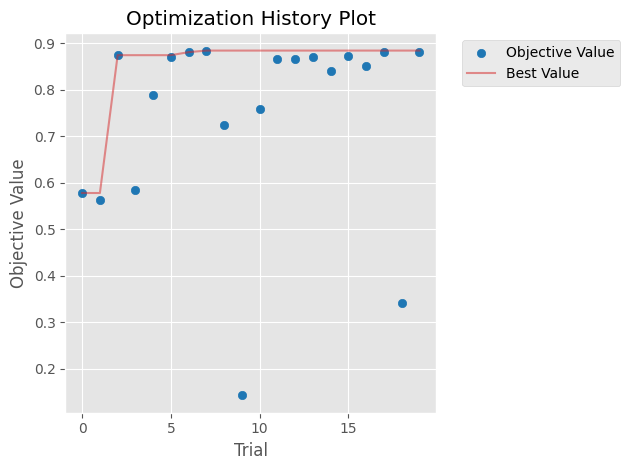

In [29]:
from optuna.visualization.matplotlib import plot_optimization_history
plot_optimization_history(study_svm)


C:\Users\Mominul Hoque\AppData\Local\Temp\ipykernel_14156\3927778239.py:2: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study_svm)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

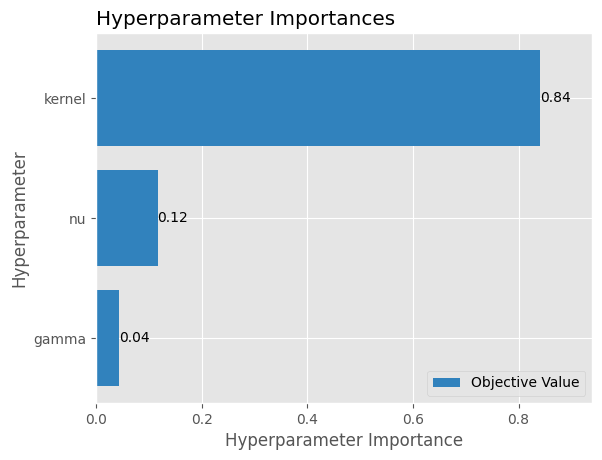

In [33]:
from optuna.visualization.matplotlib import plot_param_importances
plot_param_importances(study_svm)


In [30]:
sample_size = min(50000, len(X_train_scaled))
indices = np.random.choice(len(X_train_scaled), sample_size, replace=False)
X_train_sample = X_train_scaled[indices]

In [31]:
best_ocsvm = OneClassSVM(**study_svm.best_trial.params)
print(f"\nTraining One-Class SVM on {sample_size} samples...")
best_ocsvm.fit(X_train_sample)


Training One-Class SVM on 50000 samples...


OneClassSVM(gamma='auto', nu=0.01817987161100268)

In [33]:
print("\nFinding optimal threshold using VALIDATION set...")

# Get validation scores
val_raw_scores = best_ocsvm.decision_function(X_val_scaled)
val_y_scores = -1 * val_raw_scores  # Invert: HIGH = anomaly

# Use Precision-Recall curve to find optimal threshold
precision, recall, thresholds = precision_recall_curve(y_val, val_y_scores)

# Calculate F1 for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

# Find best threshold
best_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[best_idx]
best_val_f1 = f1_scores[best_idx]


Finding optimal threshold using VALIDATION set...


In [34]:
print(f"   Validation F1: {best_val_f1:.4f}")
print(f"   Validation Precision: {precision[best_idx]:.4f}")
print(f"   Validation Recall: {recall[best_idx]:.4f}")

   Validation F1: 0.9300
   Validation Precision: 0.9112
   Validation Recall: 0.9496


In [35]:
optimal_threshold

np.float64(0.016838153728526192)

In [37]:
# Get test scores
test_raw_scores = best_ocsvm.decision_function(X_test_scaled)
test_y_scores = -1 * test_raw_scores

# Apply optimal threshold
final_predictions = (test_y_scores >= optimal_threshold).astype(int)

# Calculate comprehensive metrics
test_f1 = f1_score(y_test, final_predictions)
test_auc = roc_auc_score(y_test, test_y_scores)
test_balanced_acc = balanced_accuracy_score(y_test, final_predictions)

In [38]:
print(f"   F1 Score: {test_f1:.4f}")
print(f"   ROC-AUC: {test_auc:.4f}")
print(f"   Balanced Accuracy: {test_balanced_acc:.4f}")

   F1 Score: 0.9306
   ROC-AUC: 0.8764
   Balanced Accuracy: 0.8874


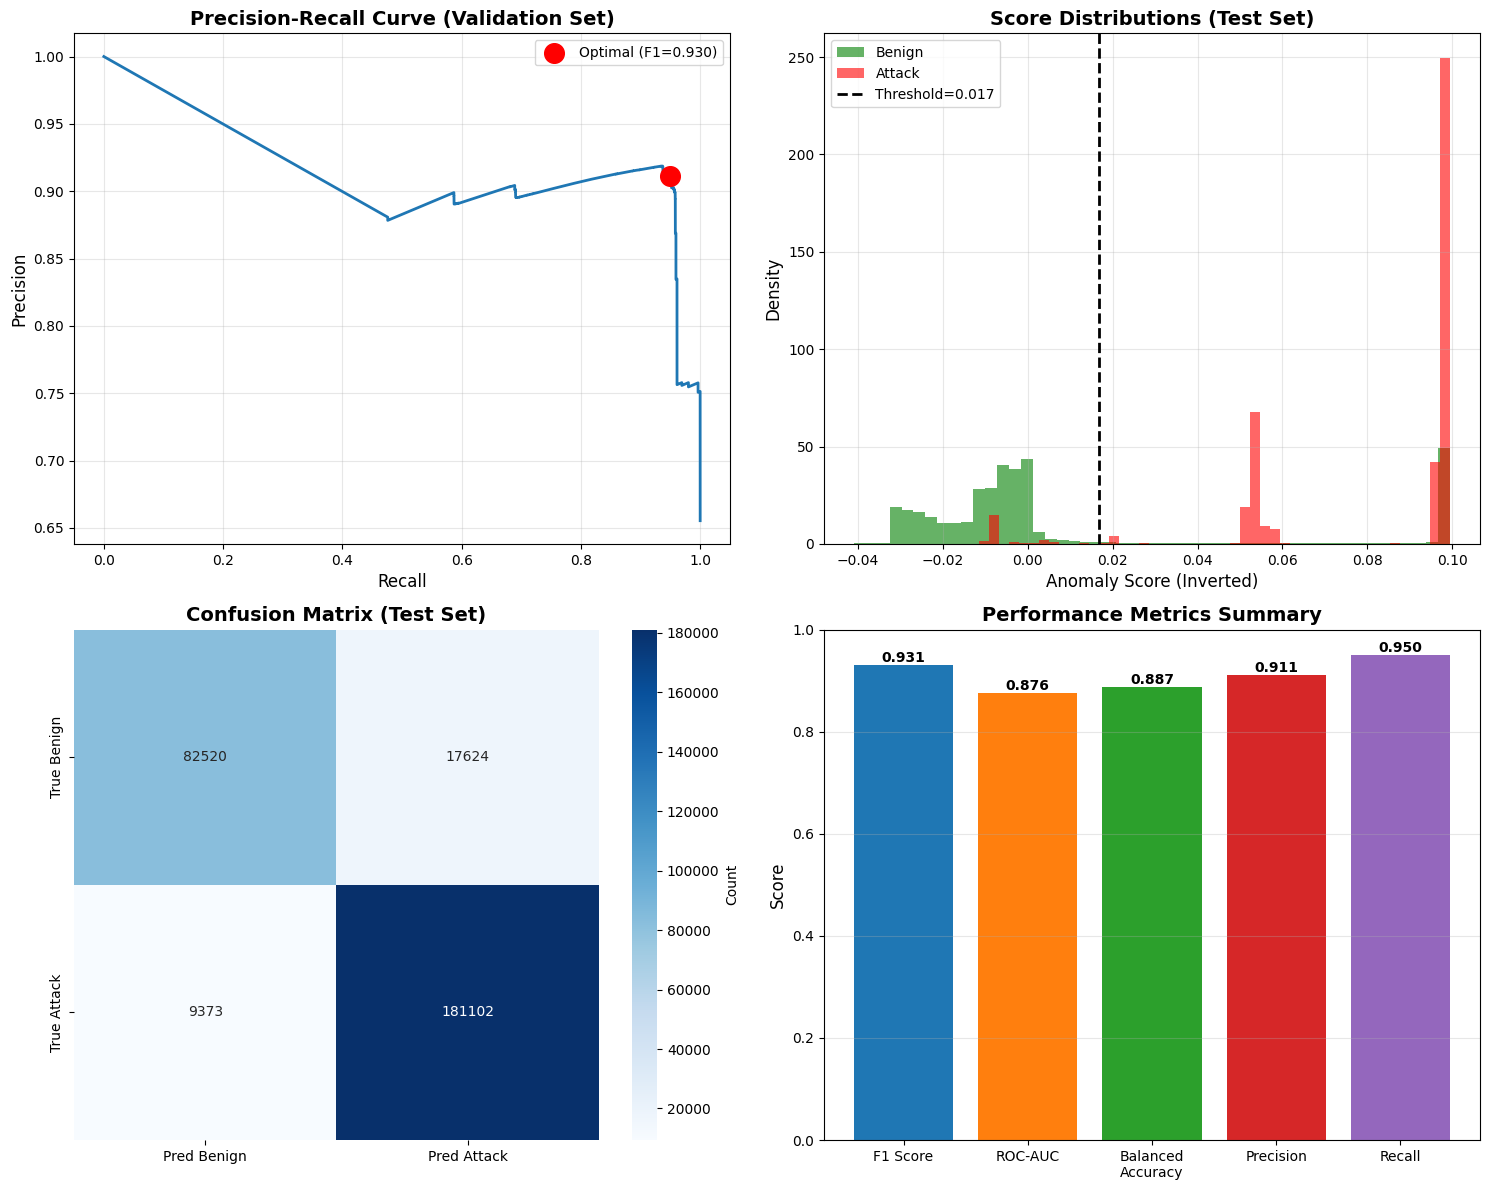

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Precision-Recall Curve
ax1 = axes[0, 0]
ax1.plot(recall, precision, linewidth=2)
ax1.scatter(
    recall[best_idx], 
    precision[best_idx], 
    color='red', 
    s=200, 
    zorder=5,
    label=f'Optimal (F1={best_val_f1:.3f})'
)
ax1.set_xlabel('Recall', fontsize=12)
ax1.set_ylabel('Precision', fontsize=12)
ax1.set_title('Precision-Recall Curve (Validation Set)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Score Distribution
ax2 = axes[0, 1]
ax2.hist(
    test_y_scores[y_test==0], 
    bins=50, 
    alpha=0.6, 
    label='Benign', 
    color='green',
    density=True
)
ax2.hist(
    test_y_scores[y_test==1], 
    bins=50, 
    alpha=0.6, 
    label='Attack', 
    color='red',
    density=True
)
ax2.axvline(
    optimal_threshold, 
    color='black', 
    linestyle='--', 
    linewidth=2,
    label=f'Threshold={optimal_threshold:.3f}'
)
ax2.set_xlabel('Anomaly Score (Inverted)', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Score Distributions (Test Set)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Confusion Matrix
ax3 = axes[1, 0]
cm = confusion_matrix(y_test, final_predictions)
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    ax=ax3,
    xticklabels=['Pred Benign', 'Pred Attack'],
    yticklabels=['True Benign', 'True Attack'],
    cbar_kws={'label': 'Count'}
)
ax3.set_title('Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')

# Plot 4: Metrics Comparison
ax4 = axes[1, 1]
metrics = {
    'F1 Score': test_f1,
    'ROC-AUC': test_auc,
    'Balanced\nAccuracy': test_balanced_acc,
    'Precision': precision[best_idx],
    'Recall': recall[best_idx]
}
bars = ax4.bar(metrics.keys(), metrics.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
ax4.set_ylim(0, 1)
ax4.set_ylabel('Score', fontsize=12)
ax4.set_title('Performance Metrics Summary', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax4.text(
        bar.get_x() + bar.get_width()/2., 
        height,
        f'{height:.3f}',
        ha='center', 
        va='bottom',
        fontweight='bold'
    )

plt.tight_layout()
plt.savefig('isolation_forest_results.png', dpi=300, bbox_inches='tight')
plt.show()